Maximum absolute error: 8.529918e-04
L2 error: 2.886627e-04


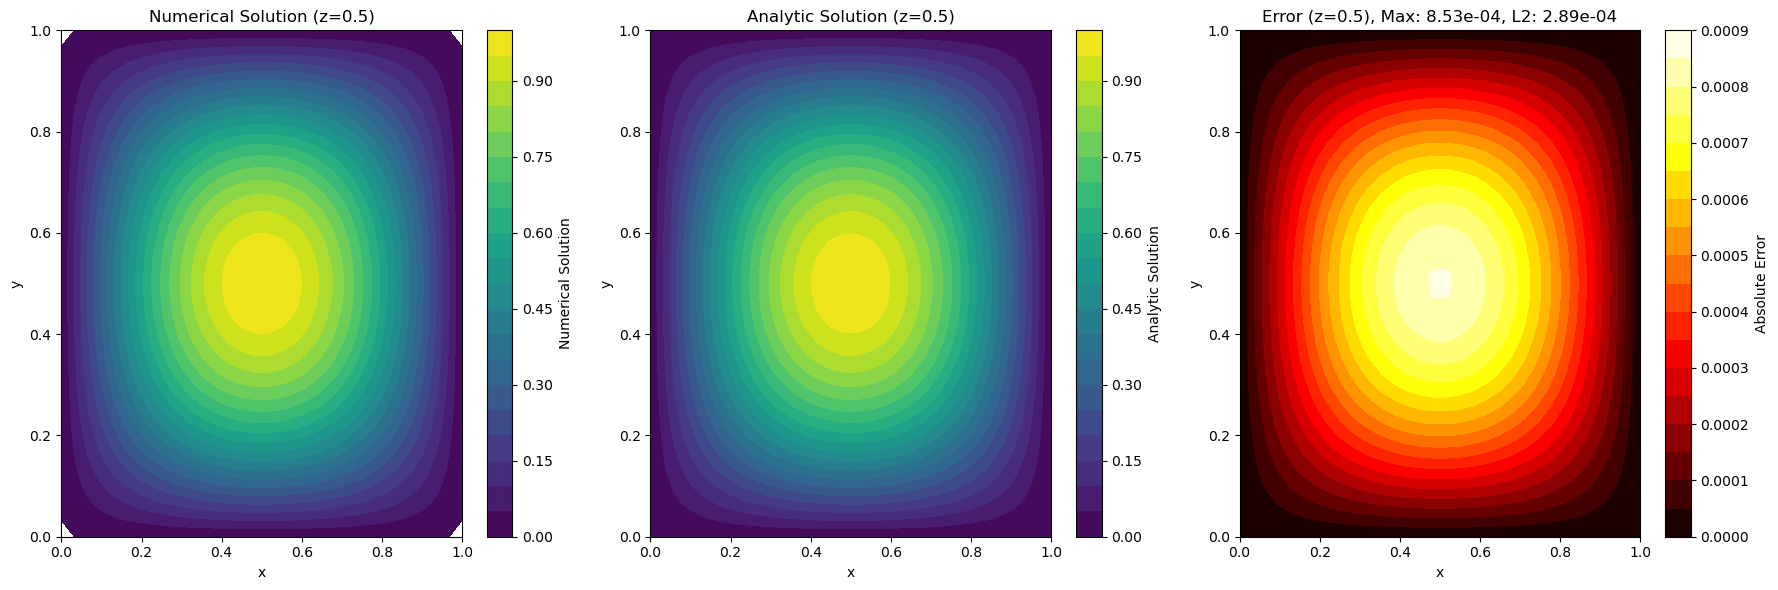

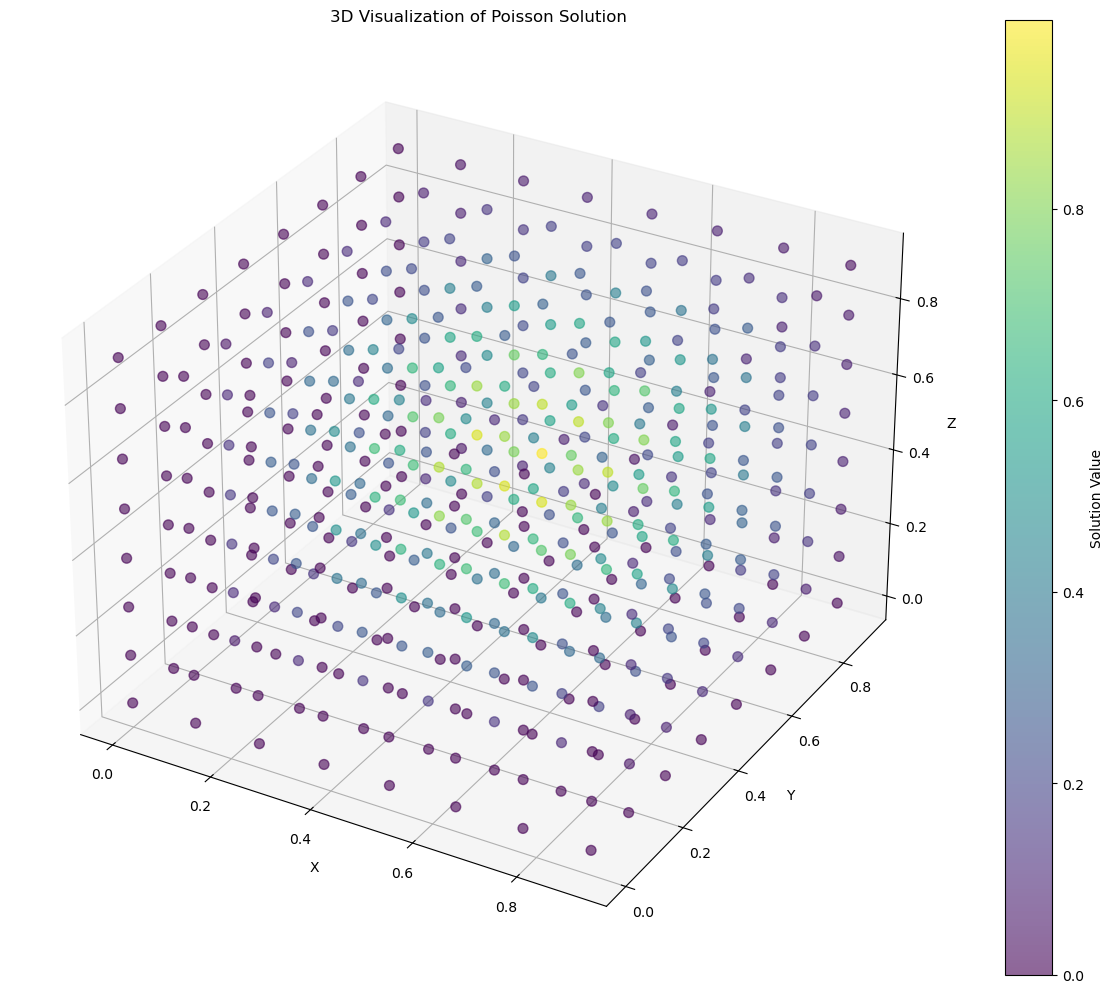

Running convergence test with grid size 8x8x8
Running convergence test with grid size 16x16x16
Running convergence test with grid size 32x32x32
Running convergence test with grid size 64x64x64


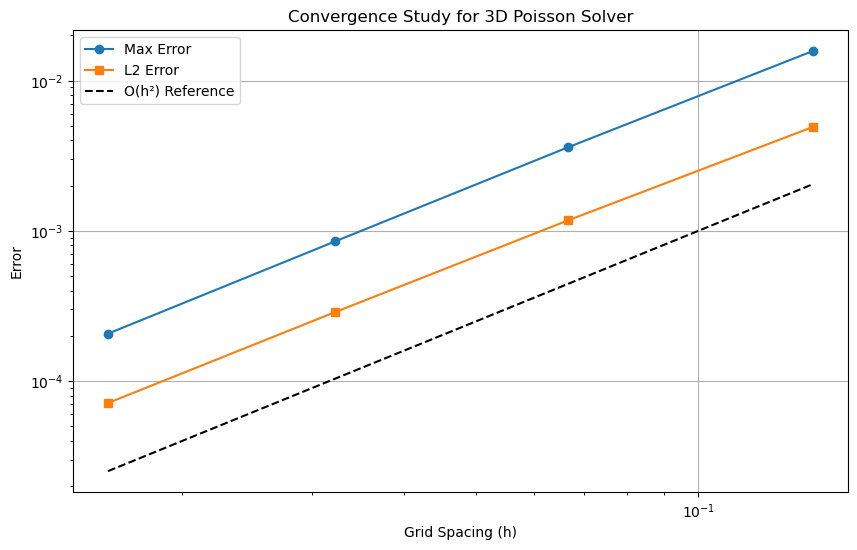

Grid refinement 8 -> 16:
  Max error convergence rate: 2.12
  L2 error convergence rate: 2.06
Grid refinement 16 -> 32:
  Max error convergence rate: 2.08
  L2 error convergence rate: 2.03
Grid refinement 32 -> 64:
  Max error convergence rate: 2.04
  L2 error convergence rate: 2.01


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import os

# Add the path to the fastsolver module
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'build'))

try:
    import fastsolver
except ImportError:
    print("Error: fastsolver module not found. Make sure it's built and in the correct path.")
    sys.exit(1)

# Define an analytic solution to the Poisson equation
# We'll use u(x,y,z) = sin(πx)sin(πy)sin(πz)
# For this function, ∇²u = -3π²sin(πx)sin(πy)sin(πz)

def analytic_solution(x, y, z):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.sin(np.pi*z)

def source_function(x, y, z):
    # The right-hand side of the Poisson equation: ∇²u = f
    # For our analytic solution, f = -3π²sin(πx)sin(πy)sin(πz)
    return -3 * np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y) * np.sin(np.pi*z)

def boundary_function(x, y, z):
    # Dirichlet boundary conditions matching the analytic solution
    return analytic_solution(x, y, z)

# Set up the domain and grid
nx, ny, nz = 32, 32, 32  # Number of grid points
lx, ly, lz = 1.0, 1.0, 1.0  # Domain size

# Create the Poisson solver using the new Poisson3DSolver class
poisson_solver = fastsolver.Poisson3DSolver(nx, ny, nz, lx, ly, lz)

# Set the right-hand side function and boundary conditions
poisson_solver.setRHS(source_function)
poisson_solver.setDirichletBC(boundary_function)

# Solve the Poisson equation using Conjugate Gradient
max_iter = 2000
tol = 1e-6
poisson_solver.solve(max_iter, tol)

# Extract the numerical solution
numerical_solution = np.zeros((nx, ny, nz))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            numerical_solution[i, j, k] = poisson_solver.getSolution(i, j, k)

# Calculate the analytic solution on the grid
hx, hy, hz = lx/(nx-1), ly/(ny-1), lz/(nz-1)
analytic_grid = np.zeros((nx, ny, nz))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            x, y, z = i*hx, j*hy, k*hz
            analytic_grid[i, j, k] = analytic_solution(x, y, z)

# Calculate error
error = np.abs(numerical_solution - analytic_grid)
max_error = np.max(error)
l2_error = np.sqrt(np.mean(error**2))

print(f"Maximum absolute error: {max_error:.6e}")
print(f"L2 error: {l2_error:.6e}")

# Visualize the results
# Let's create a slice through the middle of the domain
mid_z = nz // 2

# Create coordinate grids for plotting
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

# Plot the numerical solution
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.contourf(X, Y, numerical_solution[:, :, mid_z].T, 20, cmap=cm.viridis)
plt.colorbar(label='Numerical Solution')
plt.title('Numerical Solution (z=0.5)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(132)
plt.contourf(X, Y, analytic_grid[:, :, mid_z].T, 20, cmap=cm.viridis)
plt.colorbar(label='Analytic Solution')
plt.title('Analytic Solution (z=0.5)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(133)
plt.contourf(X, Y, error[:, :, mid_z].T, 20, cmap=cm.hot)
plt.colorbar(label='Absolute Error')
plt.title(f'Error (z=0.5), Max: {max_error:.2e}, L2: {l2_error:.2e}')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

# 3D visualization of the solution
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a coarser grid for 3D visualization
stride = 4
x_coarse = x[::stride]
y_coarse = y[::stride]
z_coarse = np.linspace(0, lz, nz)[::stride]
X_coarse, Y_coarse, Z_coarse = np.meshgrid(x_coarse, y_coarse, z_coarse, indexing='ij')

# Extract values at the coarser grid
values = numerical_solution[::stride, ::stride, ::stride]

# Create a 3D scatter plot with colors representing the solution values
scatter = ax.scatter(X_coarse.flatten(), Y_coarse.flatten(), Z_coarse.flatten(), 
                    c=values.flatten(), cmap=cm.viridis, s=50, alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of Poisson Solution')
plt.colorbar(scatter, ax=ax, label='Solution Value')

plt.tight_layout()
plt.show()

# Convergence study
grid_sizes = [8, 16, 32, 64]
errors_max = []
errors_l2 = []

for n in grid_sizes:
    print(f"Running convergence test with grid size {n}x{n}x{n}")
    # Use the new Poisson3DSolver for the convergence study
    solver = fastsolver.Poisson3DSolver(n, n, n, lx, ly, lz)
    solver.setRHS(source_function)
    solver.setDirichletBC(boundary_function)
    solver.solve(max_iter, tol)
    
    # Extract solution and calculate error
    h = lx/(n-1)
    numerical = np.zeros((n, n, n))
    analytic = np.zeros((n, n, n))
    
    for k in range(n):
        for j in range(n):
            for i in range(n):
                numerical[i, j, k] = solver.getSolution(i, j, k)
                x, y, z = i*h, j*h, k*h
                analytic[i, j, k] = analytic_solution(x, y, z)
    
    error = np.abs(numerical - analytic)
    errors_max.append(np.max(error))
    errors_l2.append(np.sqrt(np.mean(error**2)))

# Plot convergence
plt.figure(figsize=(10, 6))
h_values = [lx/(n-1) for n in grid_sizes]

plt.loglog(h_values, errors_max, 'o-', label='Max Error')
plt.loglog(h_values, errors_l2, 's-', label='L2 Error')

# Add reference lines for 2nd order convergence
ref_h = np.array([min(h_values), max(h_values)])
ref_error = 0.1 * ref_h**2
plt.loglog(ref_h, ref_error, 'k--', label='O(h²) Reference')

plt.xlabel('Grid Spacing (h)')
plt.ylabel('Error')
plt.title('Convergence Study for 3D Poisson Solver')
plt.legend()
plt.grid(True)
plt.show()

# Print convergence rates
for i in range(1, len(grid_sizes)):
    rate_max = np.log(errors_max[i-1]/errors_max[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
    rate_l2 = np.log(errors_l2[i-1]/errors_l2[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
    print(f"Grid refinement {grid_sizes[i-1]} -> {grid_sizes[i]}:")
    print(f"  Max error convergence rate: {rate_max:.2f}")
    print(f"  L2 error convergence rate: {rate_l2:.2f}")

Maximum absolute error: 5.019863e-01
L2 error: 2.758866e-01


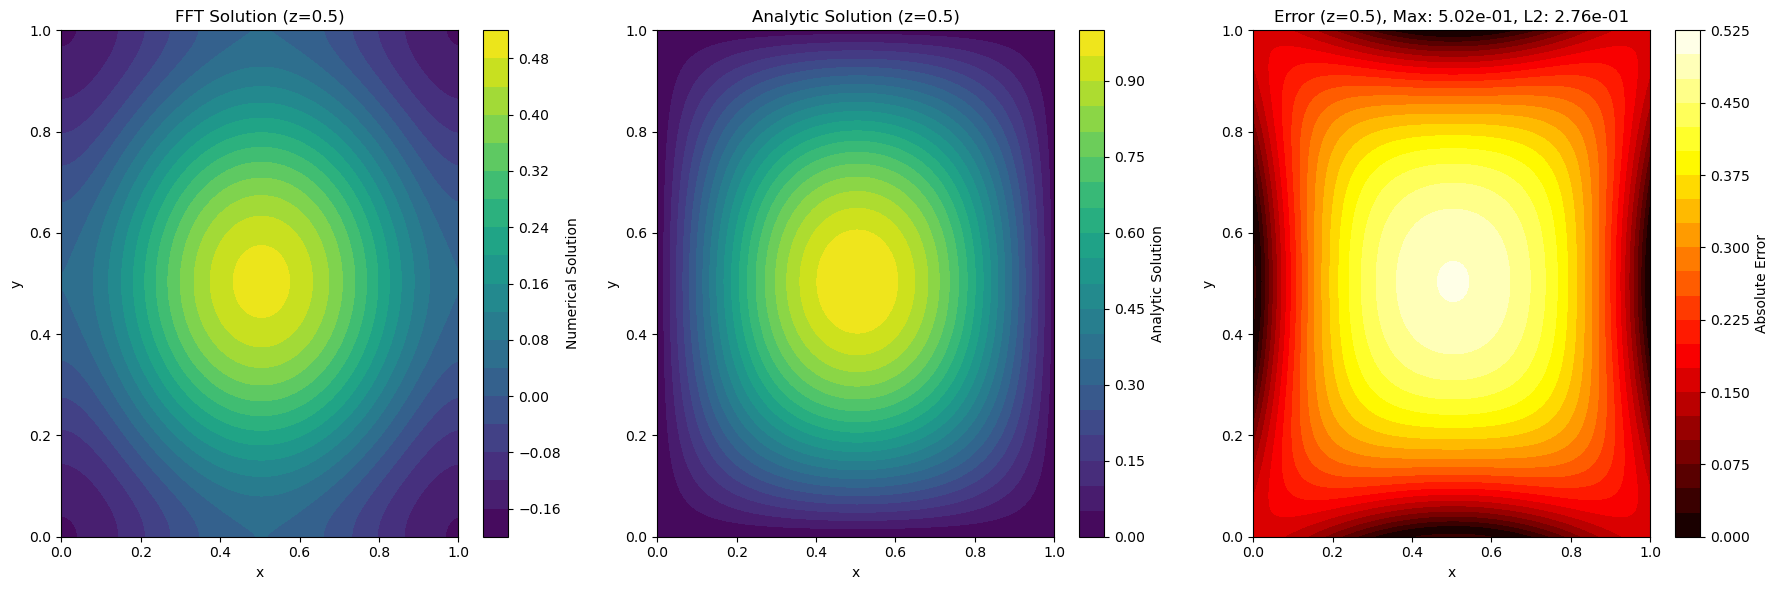

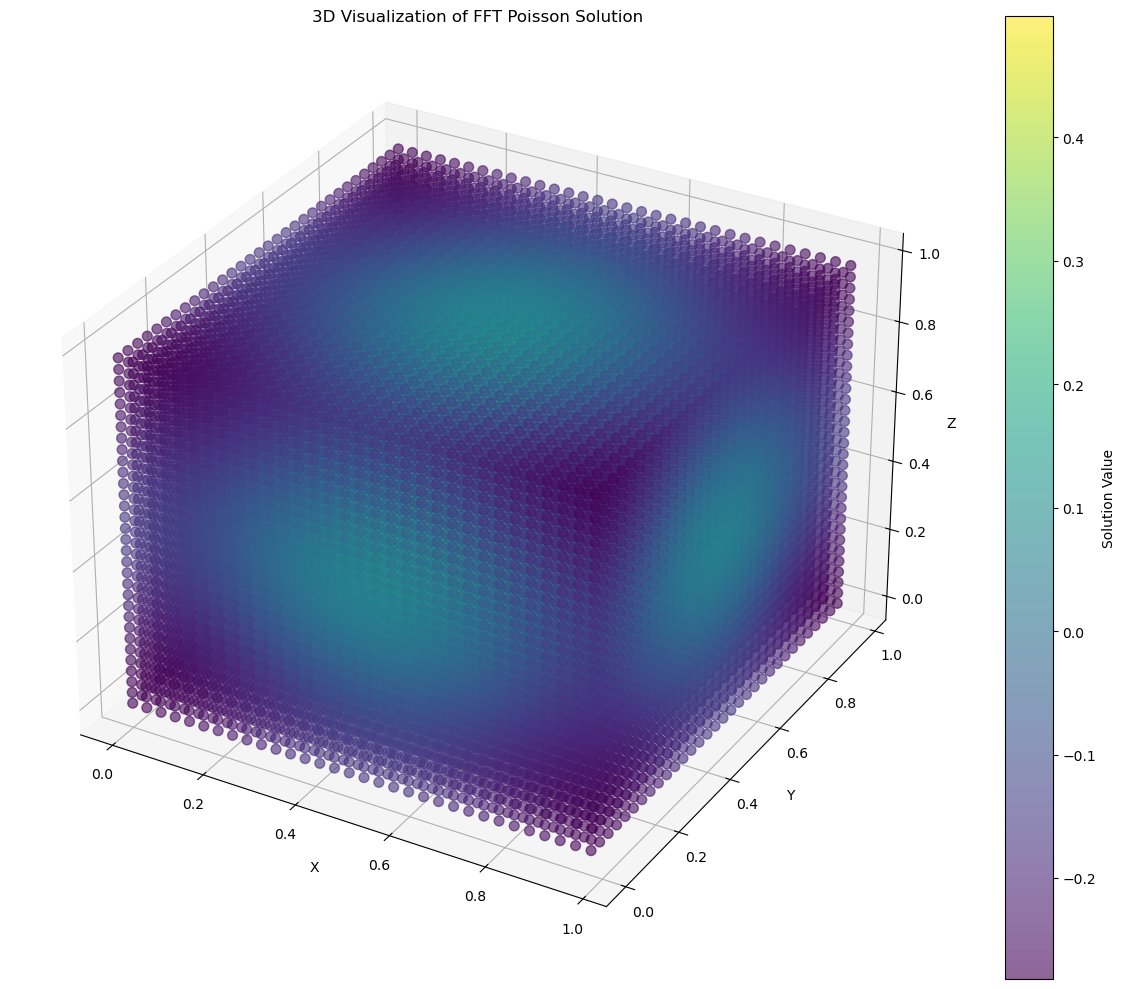

Running convergence test with grid size 8x8x8
Running convergence test with grid size 16x16x16
Running convergence test with grid size 32x32x32
Running convergence test with grid size 64x64x64


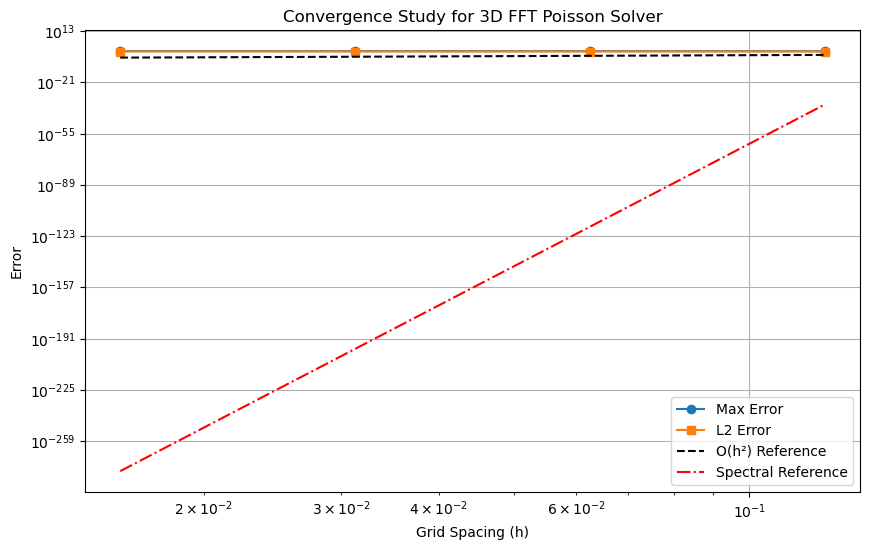

Grid refinement 8 -> 16:
  Max error convergence rate: -0.02
  L2 error convergence rate: -0.02
Grid refinement 16 -> 32:
  Max error convergence rate: -0.01
  L2 error convergence rate: -0.00
Grid refinement 32 -> 64:
  Max error convergence rate: -0.00
  L2 error convergence rate: -0.00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sys
import os

# Add the path to the fastsolver module
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'build'))

try:
    import fastsolver
except ImportError:
    print("Error: fastsolver module not found. Make sure it's built and in the correct path.")
    sys.exit(1)

# Define an analytic solution to the Poisson equation
# We'll use u(x,y,z) = sin(πx)sin(πy)sin(πz)
# For this function, ∇²u = -3π²sin(πx)sin(πy)sin(πz)

def analytic_solution(x, y, z):
    return np.sin(np.pi*x) * np.sin(np.pi*y) * np.sin(np.pi*z)

def source_function(x, y, z):
    # The right-hand side of the Poisson equation: ∇²u = f
    # For our analytic solution, f = -3π²sin(πx)sin(πy)sin(πz)
    return -3 * np.pi**2 * np.sin(np.pi*x) * np.sin(np.pi*y) * np.sin(np.pi*z)

# Set up the domain and grid
nx, ny, nz = 128, 128, 128  # Number of grid points
lx, ly, lz = 1.0, 1.0, 1.0  # Domain size

# Create the Poisson solver using the FastPoisson3D class
poisson_solver = fastsolver.FastPoisson3D(nx, ny, nz, lx, ly, lz)

# Create the right-hand side vector
f = fastsolver.Vector(nx * ny * nz)
dx = poisson_solver.getDx()
dy = poisson_solver.getDy()
dz = poisson_solver.getDz()

# Fill the right-hand side vector with the source function values
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            x, y, z = i*dx, j*dy, k*dz
            idx = poisson_solver.index(i, j, k)
            f[idx] = source_function(x, y, z)

# Solve the Poisson equation using FFT
solution = poisson_solver.solve(f)

# Extract the numerical solution
numerical_solution = np.zeros((nx, ny, nz))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            idx = poisson_solver.index(i, j, k)
            numerical_solution[i, j, k] = solution[idx]

# Calculate the analytic solution on the grid
analytic_grid = np.zeros((nx, ny, nz))
for k in range(nz):
    for j in range(ny):
        for i in range(nx):
            x, y, z = i*dx, j*dy, k*dz
            analytic_grid[i, j, k] = analytic_solution(x, y, z)

# Calculate error
error = np.abs(numerical_solution - analytic_grid)
max_error = np.max(error)
l2_error = np.sqrt(np.mean(error**2))

print(f"Maximum absolute error: {max_error:.6e}")
print(f"L2 error: {l2_error:.6e}")

# Visualize the results
# Let's create a slice through the middle of the domain
mid_z = nz // 2

# Create coordinate grids for plotting
x = np.linspace(0, lx, nx)
y = np.linspace(0, ly, ny)
X, Y = np.meshgrid(x, y)

# Plot the numerical solution
plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.contourf(X, Y, numerical_solution[:, :, mid_z].T, 20, cmap=cm.viridis)
plt.colorbar(label='Numerical Solution')
plt.title('FFT Solution (z=0.5)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(132)
plt.contourf(X, Y, analytic_grid[:, :, mid_z].T, 20, cmap=cm.viridis)
plt.colorbar(label='Analytic Solution')
plt.title('Analytic Solution (z=0.5)')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(133)
plt.contourf(X, Y, error[:, :, mid_z].T, 20, cmap=cm.hot)
plt.colorbar(label='Absolute Error')
plt.title(f'Error (z=0.5), Max: {max_error:.2e}, L2: {l2_error:.2e}')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

# 3D visualization of the solution
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a coarser grid for 3D visualization
stride = 4
x_coarse = x[::stride]
y_coarse = y[::stride]
z_coarse = np.linspace(0, lz, nz)[::stride]
X_coarse, Y_coarse, Z_coarse = np.meshgrid(x_coarse, y_coarse, z_coarse, indexing='ij')

# Extract values at the coarser grid
values = numerical_solution[::stride, ::stride, ::stride]

# Create a 3D scatter plot with colors representing the solution values
scatter = ax.scatter(X_coarse.flatten(), Y_coarse.flatten(), Z_coarse.flatten(), 
                    c=values.flatten(), cmap=cm.viridis, s=50, alpha=0.6)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Visualization of FFT Poisson Solution')
plt.colorbar(scatter, ax=ax, label='Solution Value')

plt.tight_layout()
plt.show()

# Convergence study
grid_sizes = [8, 16, 32, 64]
errors_max = []
errors_l2 = []

for n in grid_sizes:
    print(f"Running convergence test with grid size {n}x{n}x{n}")
    # Use the FastPoisson3D for the convergence study
    solver = fastsolver.FastPoisson3D(n, n, n, lx, ly, lz)
    
    # Create and fill the right-hand side vector
    f_vec = fastsolver.Vector(n * n * n)
    dx = solver.getDx()
    dy = solver.getDy()
    dz = solver.getDz()
    
    for k in range(n):
        for j in range(n):
            for i in range(n):
                x, y, z = i*dx, j*dy, k*dz
                idx = solver.index(i, j, k)
                f_vec[idx] = source_function(x, y, z)
    
    # Solve using FFT
    sol = solver.solve(f_vec)
    
    # Extract solution and calculate error
    numerical = np.zeros((n, n, n))
    analytic = np.zeros((n, n, n))
    
    for k in range(n):
        for j in range(n):
            for i in range(n):
                idx = solver.index(i, j, k)
                numerical[i, j, k] = sol[idx]
                x, y, z = i*dx, j*dy, k*dz
                analytic[i, j, k] = analytic_solution(x, y, z)
    
    error = np.abs(numerical - analytic)
    errors_max.append(np.max(error))
    errors_l2.append(np.sqrt(np.mean(error**2)))

# Plot convergence
plt.figure(figsize=(10, 6))
h_values = [lx/n for n in grid_sizes]  # Note: FFT uses n points, not n-1

plt.loglog(h_values, errors_max, 'o-', label='Max Error')
plt.loglog(h_values, errors_l2, 's-', label='L2 Error')

# Add reference lines for spectral convergence
ref_h = np.array([min(h_values), max(h_values)])
ref_error1 = 0.1 * ref_h**2
ref_error2 = 0.1 * np.exp(-10 * (1/ref_h))
plt.loglog(ref_h, ref_error1, 'k--', label='O(h²) Reference')
plt.loglog(ref_h, ref_error2, 'r-.', label='Spectral Reference')

plt.xlabel('Grid Spacing (h)')
plt.ylabel('Error')
plt.title('Convergence Study for 3D FFT Poisson Solver')
plt.legend()
plt.grid(True)
plt.show()

# Print convergence rates
for i in range(1, len(grid_sizes)):
    rate_max = np.log(errors_max[i-1]/errors_max[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
    rate_l2 = np.log(errors_l2[i-1]/errors_l2[i]) / np.log(grid_sizes[i]/grid_sizes[i-1])
    print(f"Grid refinement {grid_sizes[i-1]} -> {grid_sizes[i]}:")
    print(f"  Max error convergence rate: {rate_max:.2f}")
    print(f"  L2 error convergence rate: {rate_l2:.2f}")